# Food Sales App

In this project we will be investigating data from three experiment groups purchasing food through an app. The data consists of logs for each event that occured on the app over the course of several days. The user ID, timestamp, and experiment group ID is included for each event. First, we will study the event funnel for conversion rates through the various events on the app. Secondly, we will be comparing the conversion performance between the groups using A/B testing.

## Open the data file and read the general information

To begin, we will import the data and take an overview.

### IMPORT LIBRARIES & DATA

Let's import the needed libraries first.

In [69]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly import graph_objects as go
import scipy.stats as stats
import math as mth

Now, we will import our /datasets/logs_exp_us file. This file is separated with the escape character. To separate the values, we will convert all escape character instances with "\t".

In [70]:
try:
    logs_exp = pd.read_csv('logs_exp_us.csv', sep='\t')
except:
    logs_exp = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

### OVERVIEW

In [71]:
logs_exp.info()
print()
logs_exp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Everything in logs_exp looks great. There are no missing values. The data displays various events on the company app. There is a designated event name, a user (device) ID, timestamp and experiment ID (showing which A/B testing group the user was a part of).

## Prepare the data for analysis

Now, let's move on to preprocessing the data by renaming columns, reassigning data types, checking for duplicates, adding necessary columns, etc.

### Rename the columns in a way that's convenient for you

Let's remove the upper case letters (using str.lower()) and check for hidden spaces (using str.replace(" ", "_")).

In [72]:
logs_exp.columns = logs_exp.columns.str.lower().str.replace(" ", "_")
logs_exp.head()

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Everything is in lower case and there are no hidden spaces. Let's do the same with the "eventname" column.

In [73]:
logs_exp['eventname'] = logs_exp['eventname'].str.lower().str.replace(" ", "_")
logs_exp.head()

,eventname,deviceidhash,eventtimestamp,expid
0,mainscreenappear,4575588528974610257,1564029816,246
1,mainscreenappear,7416695313311560658,1564053102,246
2,paymentscreensuccessful,3518123091307005509,1564054127,248
3,cartscreenappear,3518123091307005509,1564054127,248
4,paymentscreensuccessful,6217807653094995999,1564055322,248


This will help us discover potential duplicates, regardless of capitalization or extra spaces.

### Duplicates & Data Types

We know from our initial .info() overview that there is no missing data. Let's check for duplicates

In [74]:
print(len(logs_exp[logs_exp.duplicated()]))
logs_exp[logs_exp.duplicated()].head()

413


,eventname,deviceidhash,eventtimestamp,expid
453,mainscreenappear,5613408041324010552,1564474784,248
2350,cartscreenappear,1694940645335807244,1564609899,248
3573,mainscreenappear,434103746454591587,1564628377,248
4076,mainscreenappear,3761373764179762633,1564631266,247
4803,mainscreenappear,2835328739789306622,1564634641,248


There are 413 duplicate rows. That is a negligible amount, less than 1%. We will drop these duplicated records using .drop_duplicates().

In [75]:
logs_exp.drop_duplicates(inplace=True) 
logs_exp.head()

,eventname,deviceidhash,eventtimestamp,expid
0,mainscreenappear,4575588528974610257,1564029816,246
1,mainscreenappear,7416695313311560658,1564053102,246
2,paymentscreensuccessful,3518123091307005509,1564054127,248
3,cartscreenappear,3518123091307005509,1564054127,248
4,paymentscreensuccessful,6217807653094995999,1564055322,248


Let's convert expid to int8 to save on data space.

In [76]:
logs_exp['eventtimestamp'] = pd.to_datetime(logs_exp['eventtimestamp'], unit='s')
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       243713 non-null  object        
 1   deviceidhash    243713 non-null  int64         
 2   eventtimestamp  243713 non-null  datetime64[ns]
 3   expid           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Data types all look good now.

### Add a column for dates

We now have a date and time column represented by the "eventtimestamp" column of which the data type has just been changed. Now, let's create a column representing the date alone. We will also convert it to DateTime.

In [77]:
logs_exp['date']  = pd.DatetimeIndex(logs_exp['eventtimestamp']).date
logs_exp['date'] = pd.to_datetime(logs_exp['date'])
logs_exp.head()

,eventname,deviceidhash,eventtimestamp,expid,date
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Preproccesing Summary

Everything looks good now. We have dropped duplicates, converted experiment groups to object data type and converted timestamps to DateTime, and added a date column. Preprocessing is complete.

## Study and Check Data

### Unique Events

Let's find out how many unique events occur in the data by applying .unique() to the "eventname" column. We will also print the event labels themselves using .unique().

In [78]:
unique_events = logs_exp['eventname'].nunique()
print(logs_exp['eventname'].unique())
print()
print('Total Number of Events: ', len(logs_exp))

['mainscreenappear' 'paymentscreensuccessful' 'cartscreenappear'
 'offersscreenappear' 'tutorial']

Total Number of Events:  243713


There are five unique events: 'mainscreenappear', 'paymentscreensuccessful', 'cartscreenappear',
 'offersscreenappear', and 'tutorial'

### Unique Users

Let's find out how many unique users occur in the data by applying .nunique() to the "deviceidhash" column.

In [79]:
unique_users = logs_exp['deviceidhash'].nunique()

There are 7,551 unique users.

### Average Events per User

Now let's calculate average events per user by dividing the total number of rows by the unique_users.

In [80]:
events_per_user = len(logs_exp) / unique_users
print('Average Events per User: {0:.0f}'.format(events_per_user))

Average Events per User: 32


Let's take a look at how they are distributed. First we will group by user, and count the number of events for each.

In [81]:
events_distribution = logs_exp.groupby('deviceidhash').agg({'eventname' : 'count'})
events_distribution.head()

,eventname
deviceidhash,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


Now, let's plot a histogram showing the frequency of each user's number of events.

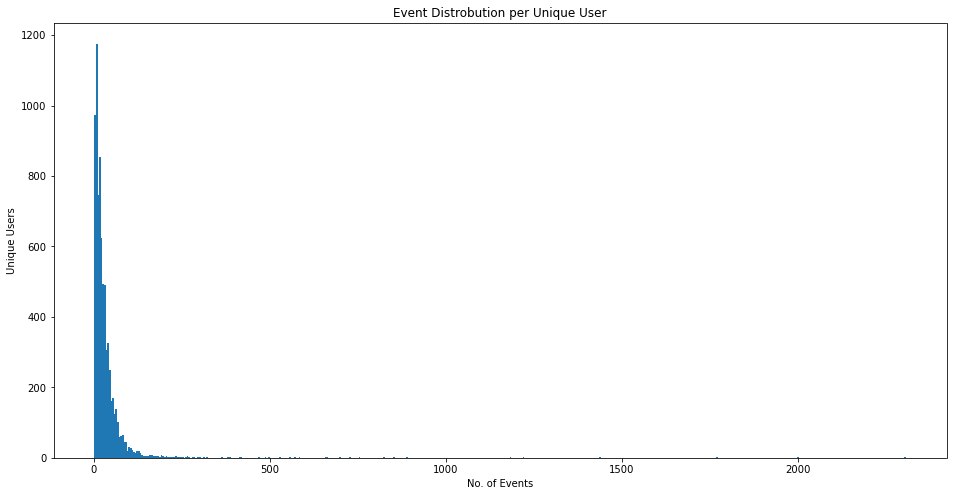

Median of Events per User: 20


In [82]:
plt.figure(figsize=(16, 8))
plt.hist(data=events_distribution, x='eventname', bins=(500))
plt.title('Event Distrobution per Unique User')
plt.ylabel('Unique Users')
plt.xlabel('No. of Events')
plt.show()

print('Median of Events per User: {0:.0f}'.format(events_distribution['eventname'].median()))

Although the mean is 32, We can see here that most users fall below 32 events, but the mean is pulled higher due to a few users with massive numbers of events, at least one of which reaches over 2,000.

### Time Period

Let's find the first and last date of the period represented by the data. To do this, we will use .min() and .max().

In [83]:
min_date = logs_exp['date'].min()
print('Period Starting Date:', min_date)

Period Starting Date: 2019-07-25 00:00:00


In [84]:
max_date = logs_exp['date'].max()
print('Period Ending Date:', max_date)

Period Ending Date: 2019-08-07 00:00:00


Now, let's plot a histogram by date to see how the data is distributed per day.

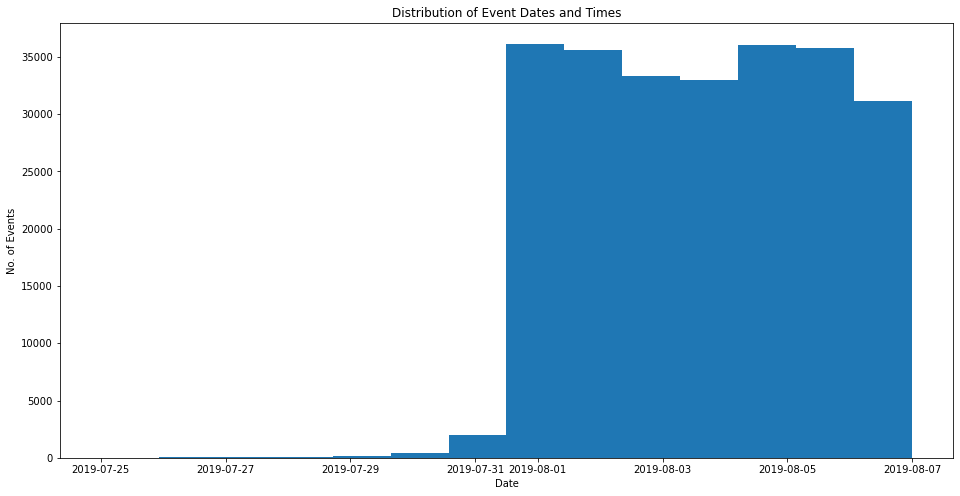

In [85]:
plt.figure(figsize=(16, 8))
plt.hist(data=logs_exp, x='date', bins=(14))
plt.title('Distribution of Event Dates and Times')
plt.ylabel('No. of Events')
plt.xlabel('Date')
plt.show()

It appears that most of the data occurs after the month of July. Older events must have ended up in some users' logs for technical reasons. We will need to account for this later if we do not want to skew the data. The period of time actually represented by the data is actually the first seven days of August.

### Impact of Filtering Data Prior to Actual Period

Let's make a slice including only data for the first seven days of August to find out what changes.

In [86]:
logs_exp_august = logs_exp.loc[logs_exp.loc[:,'date'] > '2019-07-31']
logs_exp_august.head()

,eventname,deviceidhash,eventtimestamp,expid,date
2828,tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,mainscreenappear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,mainscreenappear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,offersscreenappear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,mainscreenappear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


Let's check how many events remain in the data after the slice.

In [87]:
percentage_events_remaining = len(logs_exp_august) / len(logs_exp)
print('Percentage of events retained after slicing for August only:', percentage_events_remaining)

Percentage of events retained after slicing for August only: 0.988404393692581


We still have almost 99% of our events. Now, let's check how many users were lost. First we will count the unique users in our new slice.

In [88]:
august_users = logs_exp_august['deviceidhash'].nunique()
august_users

7534

Now, let's find the percentage.

In [89]:
percentage_users_remaining = august_users / unique_users
print('Percentage of users retained after slicing for August only:', percentage_users_remaining)

Percentage of users retained after slicing for August only: 0.9977486425638988


Less than 1% of users were lost in the slice.

### Three Experimental Groups

Finally, we will double check to make sure all three experiment groups are represented. Let's group by expid and date to count how many records there are for each.

In [90]:
logs_exp_august.groupby(['expid', 'date']).agg({'eventname' : 'count'})

eventname
expid date                 
246   2019-08-01      11561
      2019-08-02      10946
      2019-08-03      10575
      2019-08-04      11514
      2019-08-05      12368
      2019-08-06      11726
      2019-08-07      10612
247   2019-08-01      12306
      2019-08-02      10990
      2019-08-03      11024
      2019-08-04       9942
      2019-08-05      10949
      2019-08-06      11720
      2019-08-07      10091
248   2019-08-01      12274
      2019-08-02      13618
      2019-08-03      11683
      2019-08-04      11512
      2019-08-05      12741
      2019-08-06      12342
      2019-08-07      10393

We can see clearly here that all three experiment groups are represented for all seven days of the period.

### Study/Data Check Summary

We have identified five event types and 7,551 unique users who average 32 events over the seven day period. We have made the required slice to remove data occurring before the period of interest. We still have around 99% of our data remaining, and all three experimental groups for all seven days of the period are well represented. Let's move on to the event funnel.

## Study the event funnel

### Event Frequency

Let's .groupby() event and sort them acording to frequency.

In [91]:
logs_exp_august.groupby('eventname').agg({'eventtimestamp' : 'count'})\
.sort_values('eventtimestamp', ascending=False).reset_index()

,eventname,eventtimestamp
0,mainscreenappear,117328
1,offersscreenappear,46333
2,cartscreenappear,42303
3,paymentscreensuccessful,33918
4,tutorial,1005


As could be expected, the main screen is the most common event to occur.

### Unique Users and User Proportions per Event

Let's use the same methods to take a look at how many unique users engaged with each event type.

In [92]:
funnel_chart = logs_exp_august.groupby('eventname').agg({'deviceidhash' : 'nunique'})\
.sort_values('deviceidhash', ascending=False).reset_index()

The result is similar to the number of events. Let's add a column showing the proportion of total unique users who encountered each event.

In [93]:
funnel_chart['proportion'] = funnel_chart['deviceidhash'] / len(logs_exp_august['deviceidhash'].unique())

funnel_chart

,eventname,deviceidhash,proportion
0,mainscreenappear,7419,0.984736
1,offersscreenappear,4593,0.609636
2,cartscreenappear,3734,0.495620
3,paymentscreensuccessful,3539,0.469737
4,tutorial,840,0.111495


### Event Sequence

Users begin on the main screen. Some find their way to the offer screen. If they select an item, they reach the cart screen. If they complete their purchase, they reach the payment successful screen. Users are filtered out at each stage.

A few users engage with the tutorial as well. The tutorial screen will not be an applicable event in the funnel. The tutorial is optional and can be done at any stage in time. It has no logical place in the event funnel.

### Event Funnel

Now, let's plot the event funnel chart. To do this, we will first remove the tutorial event from our funnel_chart table.

In [94]:
funnel_chart = funnel_chart.loc[funnel_chart.loc[:,'eventname'] != 'tutorial']
funnel_chart

,eventname,deviceidhash,proportion
0,mainscreenappear,7419,0.984736
1,offersscreenappear,4593,0.609636
2,cartscreenappear,3734,0.495620
3,paymentscreensuccessful,3539,0.469737


Now, let's plot an interactive chart using the graph_objects library and .funnel().

In [95]:
fig = go.Figure(go.Funnel(
    y = ['Main Screen', 'Offer Screen', 'Cart Screen', 'Payment Successful Screen'],
    x = funnel_chart['deviceidhash']
    ))
fig.update_layout(title_text='Event Funnel')
fig.show()

Here is our event funnel chart. It is interactive, and the conversion rates can be observed by hovering your mouse over the bars. We will also manually calculate the conversion rates below.

As can be seen from our event funnel, most users are lost between the main screen and the offer screen. Let's look at the overall average.

In [96]:
print('Conversion rate from main screen to offer screen: {0:.2f}%'.format((
    funnel_chart.loc[1, 'deviceidhash'] / funnel_chart.loc[0, 'deviceidhash']) * 100))

Conversion rate from main screen to offer screen: 61.91%


38% of users fail to make it past the initial main screen.

### User Conversion from Main Screen to Payment

Let's take a look at the overall average for main screen to payment conversion.

In [97]:
print('Conversion rate from main screen to payment: {0:.2f}%'.format((
    funnel_chart.loc[3, 'deviceidhash'] / funnel_chart.loc[0, 'deviceidhash']) * 100))

Conversion rate from main screen to payment: 47.70%


Around 48% of users who encounter the main screen also make a purchase.

### Event Funnel Summary

We have constructed and studied the event funnel. 38% of users fail to make it past the main screen. Another 48% make a purchase. The remaining 14% fall away at some point in between.

## Study the results of the experiment

### Users per Experiment Group

We have three experiment groups: 246, 247 and 248. Let's calculate total unique users for each group and show the results in a pie chart.

In [98]:
pie_chart = logs_exp_august.groupby('expid').agg({'deviceidhash' : 'nunique'}).reset_index()
pie_chart

,expid,deviceidhash
0,246,2484
1,247,2513
2,248,2537


Now we can plot a pie chart useing plt.pie().

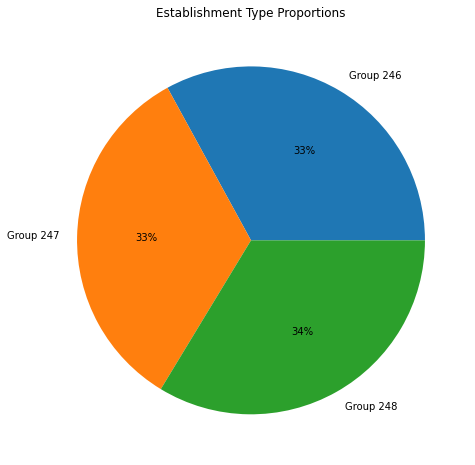

In [99]:
plt.figure(figsize=(16, 8))
plt.pie(pie_chart['deviceidhash'], labels=['Group 246', 'Group 247', 'Group 248'], autopct='%.0f%%')
plt.title('Establishment Type Proportions')
plt.show()

### Test statistically significant difference between control groups.

For the first test, we will test whether there is a statistically significant difference between our two control groups, 246 and 247. To do this, we will first create a pivot table showing the unique users per event and per group. We will also add row shoing the total unique users for each group.

In [100]:
#Create pivot table showing unique users per event and experiment group
users_per_event_and_group = logs_exp_august.loc[logs_exp_august.loc[:,'eventname'] != 'tutorial'].pivot_table(
    index='eventname', columns='expid', values='deviceidhash', aggfunc='nunique'
)

#Add total unique users column to users_per_event_and_group
users_per_event_and_group['total_users'] = users_per_event_and_group[246] + users_per_event_and_group[247] +\
users_per_event_and_group[248]

#Sort table by total_users and delete column
users_per_event_and_group = users_per_event_and_group.sort_values('total_users', ascending=False)
del users_per_event_and_group['total_users']

#Remove axis name
users_per_event_and_group = users_per_event_and_group.rename_axis(None, axis = 1)

#Add total unique trials row calculated from logs_exp_august data set
users_per_event_and_group.loc['trials', :] =  logs_exp_august.groupby('expid')['deviceidhash'].nunique().to_list()

#Reset index
users_per_event_and_group = users_per_event_and_group.reset_index()

users_per_event_and_group

,eventname,246,247,248
0,mainscreenappear,2450.0,2476.0,2493.0
1,offersscreenappear,1542.0,1520.0,1531.0
2,cartscreenappear,1266.0,1238.0,1230.0
3,paymentscreensuccessful,1200.0,1158.0,1181.0
4,trials,2484.0,2513.0,2537.0


Now, let's define a function called test_control_groups() which we can use to test whether proportions between the groups have a statistically significant difference. We will do this using stats from scipy.

In [101]:
def test_control_groups(x):
    #Declare variable for users who passed to next event
    successes = np.array([users_per_event_and_group.loc[x, 246], users_per_event_and_group.loc[x, 247]])

    #Declare variable for users from previous event
    trials  = np.array([users_per_event_and_group.loc[4, 246], users_per_event_and_group.loc[4, 247]])

    #Proportion in the first group:
    p1 = successes[0]/trials[0]

    #Proportion in the second group:
    p2 = successes[1]/trials[1]

    #Proportion in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    #Difference between the datasets' proportions
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    #Setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

Now, let's define the critical level of statistical significance as 0.05. This is the level we will be using for all tests.

In [102]:
alpha = 0.05

Now let's test the samples by pluging the row number from our users_per_event_and_group. The null hypothesis is that there is no statistically significant difference between the proportions of the control groups. The alternative hypothesis is that there IS a statistically significant difference between the proportions of the control groups.

In [103]:
print('246 vs 247 MAIN SCREEN Proportion')
test_control_groups(0)
print()
print('246 vs 247 OFFER SCREEN Proportion')
test_control_groups(1)
print()
print('246 vs 247 CART SCREEN Proportion')
test_control_groups(2)
print()
print('246 vs 247 PAYMENT SUCCESS SCREEN Proportion')
test_control_groups(3)

246 vs 247 MAIN SCREEN Proportion
p-value:  0.7570597232046099
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246 vs 247 OFFER SCREEN Proportion
p-value:  0.2480954578522181
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246 vs 247 CART SCREEN Proportion
p-value:  0.22883372237997213
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246 vs 247 PAYMENT SUCCESS SCREEN Proportion
p-value:  0.11456679313141849
Failed to reject the null hypothesis: there is no reason to consider the proportions different


It appears that proportions between the control groups are equivalent.

### Test statistically significant difference in conversion rates between combined control groups and B group

Let's run tests comparing the control groups to group 248 just as we did with the control groups before. This time, we will define a function called test_control_vs_bgroup() through which we can perform each test.

In [104]:
def test_control_vs_bgroup(x):
    #Declare variable for users who passed to next event
    successes = np.array([users_per_event_and_group.loc[x, 246] + users_per_event_and_group.loc[x, 247],
                      users_per_event_and_group.loc[x, 248]])

    #Declare variable for users from previous event
    trials  = np.array([users_per_event_and_group.loc[(4), 246] + users_per_event_and_group.loc[(4), 247],
                    users_per_event_and_group.loc[(4), 248]])

    #Proportion in the first group:
    p1 = successes[0]/trials[0]

    #Proportion in the second group:
    p2 = successes[1]/trials[1]

    #Proportion in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    #Difference between the datasets' proportions
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    #Setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

Now, we will run the row index numbers for each event and print the test results.

In [105]:
print('246+247 vs 248 MAIN SCREEN Proportion')
test_control_vs_bgroup(0)
print()
print('246+247 vs 248 OFFER SCREEN Proportion')
test_control_vs_bgroup(1)
print()
print('246+247 vs 248 CART SCREEN Proportion')
test_control_vs_bgroup(2)
print()
print('246+247 vs 248 PAYMENT SUCCESS SCREEN Proportion')
test_control_vs_bgroup(3)

246+247 vs 248 MAIN SCREEN Proportion
p-value:  0.29424526837179577
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246+247 vs 248 OFFER SCREEN Proportion
p-value:  0.43425549655188256
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246+247 vs 248 CART SCREEN Proportion
p-value:  0.18175875284404386
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246+247 vs 248 PAYMENT SUCCESS SCREEN Proportion
p-value:  0.6004294282308704
Failed to reject the null hypothesis: there is no reason to consider the proportions different


The hypothesis (that there is no significant difference between the groups) holds through all tests. So far, we cannot detect a difference between A and B groups.

### Test statistically significant difference in conversion rates between each control group and B group

Now, let's perform the same tests against each of the control groups separately. We will again define a function. This time we will call it test_against_each_control_group(), and it will require two arguments. The first one will be the index number for the event. The second one will designate the control group.

In [106]:
def test_against_each_control_group(x, z):
    #Declare variable for users who passed to next event
    successes = np.array([users_per_event_and_group.loc[x, z], users_per_event_and_group.loc[x, 248]])

    #Declare variable for users from previous event
    trials  = np.array([users_per_event_and_group.loc[4, z], users_per_event_and_group.loc[4, 248]])

    #Proportion in the first group:
    p1 = successes[0]/trials[0]

    #Proportion in the second group:
    p2 = successes[1]/trials[1]

    #Proportion in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    #Difference between the datasets' proportions
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    #Setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

Let's go ahead and run the tests for group 246.

In [107]:
print('246 vs 248 MAIN SCREEN Proportion')
test_against_each_control_group(0, 246)
print()
print('246 vs 248 OFFER SCREEN Proportion')
test_against_each_control_group(1, 246)
print()
print('246 vs 248 CART SCREEN Proportion')
test_against_each_control_group(2, 246)
print()
print('246 vs 248 PAYMENT SUCCESS SCREEN Proportion')
test_against_each_control_group(3, 246)

246 vs 248 MAIN SCREEN Proportion
p-value:  0.2949721933554552
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246 vs 248 OFFER SCREEN Proportion
p-value:  0.20836205402738917
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246 vs 248 CART SCREEN Proportion
p-value:  0.07842923237520116
Failed to reject the null hypothesis: there is no reason to consider the proportions different

246 vs 248 PAYMENT SUCCESS SCREEN Proportion
p-value:  0.2122553275697796
Failed to reject the null hypothesis: there is no reason to consider the proportions different


And now for group 247.

In [108]:
print('247 vs 248 MAIN SCREEN Proportion')
test_against_each_control_group(0, 247)
print()
print('247 vs 248 OFFER SCREEN Proportion')
test_against_each_control_group(1, 247)
print()
print('247 vs 248 CART SCREEN Proportion')
test_against_each_control_group(2, 247)
print()
print('247 vs 248 PAYMENT SUCCESS SCREEN Proportion')
test_against_each_control_group(3, 247)

247 vs 248 MAIN SCREEN Proportion
p-value:  0.4587053616621515
Failed to reject the null hypothesis: there is no reason to consider the proportions different

247 vs 248 OFFER SCREEN Proportion
p-value:  0.9197817830592261
Failed to reject the null hypothesis: there is no reason to consider the proportions different

247 vs 248 CART SCREEN Proportion
p-value:  0.5786197879539783
Failed to reject the null hypothesis: there is no reason to consider the proportions different

247 vs 248 PAYMENT SUCCESS SCREEN Proportion
p-value:  0.7373415053803964
Failed to reject the null hypothesis: there is no reason to consider the proportions different


According to these tests, neither control group is significantly different than the B group. Although, the p-values for group 246 are much lower than the p-values of group 247. This indicates that if one of the groups were to differ from the B group, group 246 is more likley to differ.

### Significance level

We chose a significance level of 0.05 for each of the 16 tests ran. Another significance level that is often used is 0.1. Glancing back at the results, only one test revealed a p-value that is lower than 0.1. It is the 246 vs 248 CART SCREEN Proportion test. Let's declare an alpha value of 0.1 and run this test once more just to see.

In [109]:
alpha = 0.1
print('246 vs 248 CART SCREEN Proportion')
test_against_each_control_group(2, 246)

246 vs 248 CART SCREEN Proportion
p-value:  0.07842923237520116
Rejecting the null hypothesis: there is a significant difference between the proportions


As can be seen here, a significance value of 0.1 would have disproven the null hypothesis. However, with 16 total tests, 0.1 is a high significance value with a high chance of confirming a false alternative hypothesis. As such, we will stick with our significance value of 0.05.

### Experiment Results Summary

The final results of testing have not confirmed a sigificant difference between the A and B groups or the A groups tested against one another, or the A groups tested seperately against the B group. Group 246 comes the closest to a statistically significant difference compared to the B group, but the alternative hypothesis is only confirmed useing a significance value of 0.1 instead of 0.05.

## Conclusion

We have studied an event funnel consisting of four events: main screen, offer screen, cart screen and payment successful screen. 38% of users fail to make it past the main screen. Another of users 48% make a purchase. The remaining 14% fall away at some point in between.

Upon testing our control group samples, no significant differences were proven between any groups. Group 246 may be approaching a statistically significant difference to group 248 (for proportions on the CART SCREEN) with a p-value of 0.07842923237520116, but it does not pass our significance value of 0.05.

With more data, we may be able to reject our null hypothesis for one or more of the above tests. However, we cannot conclude that any meaningfull difference in performance has occured for the B group with altered font.